# Wildfire Predictions Using Machine Learning Algorithms

by Ali Hossaini and Amber Benbow

The increasing prevalence of natural disasters across the world is creating an urgency to prepare for upcoming disaster events. It is no longer enough to simply react to the latest wildfire, landslide or hurricane. Instead, it is better to anticipate potential fires, rather than by reacting to them. 

Prediction of wildfires can be accomplished through the extraction of key remote sensing data points from satellite images, which can then be used to train machine learning algorithms. These algorithms are key to knowing when conditions are right for the next August Complex*. Through the replicability of programming, this process can be repeated in various locations or tweaked to accommodate different data sources and disasters.

**The August Complex is California's largest wildfire which burned more than 1 million acres in 2020.*

Here, We explore the effectiveness of different machine learning algorithms at predicting wildfires on an already gathered and pre-processed dataset. These fires occured in Canada between 2013 and 2014. For additional information about the dataset, please visit: https://github.com/ouladsayadyounes/WildFires/

## Preparing Data for Training

### Retrieving Data

The first step in any analysis is to collect the data. Here we are retrieving it from an outside source and saving it to our work space. 

In [133]:
#importing some initial libraries 
import os
import pandas as pd
import numpy as np

In [134]:
#setting working directory to the desired location
os.chdir('/Users/hossa084/Wildfire_proj')

In [135]:
#a function to download a zip file and unzip it in a desired location
def download_data(dw_url,destination):
    import wget
    import zipfile
    
    filename = wget.download(dw_url)
    print("Successfully downloaded", filename)
    
    with zipfile.ZipFile(destination + "/" + filename, 'r') as zip_ref:
        zip_ref.extractall(destination)

In [136]:
#Downloading and unzipping the data
download_data('https://github.com/ouladsayadyounes/WildFires/archive/refs/heads/master.zip','/Users/hossa084/Wildfire_proj')

Successfully downloaded WildFires-master.zip


### Loading and Preparing Data

After obtaining data, we convert it into a workable form and view it. This preview gives us an idea of what form it is in and if it needs additional changes. 

In [137]:
#opening the CSV and viewing part of it as a dataframe
wildfires = pd.read_csv('WildFires-master/WildFires_DataSet.csv', float_precision='high')
wildfires.head()

NDVI           LST  BURNED_AREA    CLASS
0  0.506782  14584.272727     4.692308  no_fire
1  0.522150  14655.833333     5.000000  no_fire
2  0.682284  14780.000000     5.000000     fire
3  0.120046  13298.500000     3.500000  no_fire
4  0.568734  14743.000000     5.000000  no_fire

With one peak we can see that the fire/no fire class will cause issues when we go to train our machine learning models. It is generally a good idea to have classes be a number as most algorithms will give a prediction using a numbered class instead of a string of text. 

In [138]:
#change the classes from strings to numbers
wildfires['CLASS'] = wildfires['CLASS'].map({'fire': 1, 'no_fire': 0})

Our next step is to separate the features from the class labels. A feature is a column within a dataset. 

In [139]:
#separating the features from the class labels
wildfire_features = wildfires.copy()
wildfire_labels = wildfire_features.pop('CLASS')
wildfire_labels.tail()

1708    0
1709    0
1710    1
1711    0
1712    1
Name: CLASS, dtype: int64

Using the pop method turns the labels into a series, which will be challenging for our alogrithms to work with. Instead, we will want them to be values.

In [140]:
#changing labels from a series to values
wildfire_labels = wildfire_labels.values
wildfire_labels

array([0, 0, 1, ..., 1, 0, 1])

Another factor to consider for good results with machine learning is to ensure that our data is normalized. When we are looking at the feature of our wildfires, we can see that the range of values between all of the features is very high. They are anywhere between 0.03 and 15611.

In [141]:
min_vals = wildfire_features.min()
max_vals = wildfire_features.max()

print(min_vals)

NDVI               0.030735
LST            13137.000000
BURNED_AREA        3.000000
dtype: float64


In [142]:
print(max_vals)

NDVI               0.781723
LST            15611.570513
BURNED_AREA        9.000000
dtype: float64


This exteremly wide range of values can skew the results of the models. The higher values may inadvertantly be given too much weight resulting in bad preditions.

For neural nets, this can cause the model to produce "constant" behavior with its predictions. The model may predict identical classes for every row instead of making a clear distinction between the class categories. For other models, chosing to normalize may improve their accuracy. **[Ali please elborate on your experiance in a sentence or two]**

In [143]:
#create two functions to normalize all columns within a dataframe
def normalize(x):
    x_med = x.median()
    x_std = x.std()
    x = ((x-x_med)/x_std)
    return x

def normalize_dataframe(pandas_df):
    pandas_df = pandas_df.apply(normalize)
    
    return pandas_df

In [144]:
#viewing the normalized features
wildfire_features = normalize_dataframe(wildfire_features) 
wildfire_features.head()

NDVI       LST  BURNED_AREA
0 -0.628978 -0.167546    -0.391111
1 -0.463460  0.027480     0.135948
2  1.261242  0.365876     0.135948
3 -4.794266 -3.671703    -2.433466
4  0.038267  0.265038     0.135948

Nice. Things are looking really good now. 

Our final step to prepare the features for training is to convert it from a dataframe to an array. Many models prefer to work with an array.

In [145]:
#convert from a dataframe to a NumPy array
wildfire_features = np.array(wildfire_features)
wildfire_features

array([[-6.28978449e-01, -1.67545939e-01, -3.91111091e-01],
       [-4.63459505e-01,  2.74804235e-02,  1.35947705e-01],
       [ 1.26124186e+00,  3.65875733e-01,  1.35947705e-01],
       ...,
       [ 5.15028005e-01,  2.88203790e-01, -3.28993790e+00],
       [ 5.30871209e-01, -2.82003661e+00,  7.16010091e-04],
       [-1.68922379e-01, -1.02464888e+00,  1.35947705e-01]])

Now, we can move into training our models.


## Train, Predict and Evaluate Machine Learning Models

The first step in training is to split our data into the features which will be trained and which will be tested on. We decided to do a 70/30 split, where approximately 30% of our dataset was held back for validating the accuracy of the models.

In [146]:
from sklearn import model_selection

#splitting my features and labels into train and test
wf_features_train, wf_features_test, wf_class_train, wf_class_test = model_selection.train_test_split(wildfire_features, wildfire_labels, test_size=0.3)

### Decision Tree

A decision tree is form of supervised machine learning. It is an algorithm made up of many branches. Each branch represents a test on an attribute and traveling down a path from root to leaf represents a classification rule. 

Here is an example of a single decision tree. For us, predictors = features, and target = class.

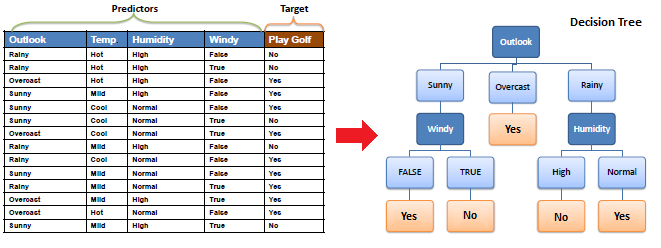

Image from: https://www.saedsayad.com/decision_tree.htm

In [147]:
# Decision tree method
from sklearn import tree

DecisionTree = tree.DecisionTreeClassifier()
DecisionTree = DecisionTree.fit(wf_features_train, wf_class_train)

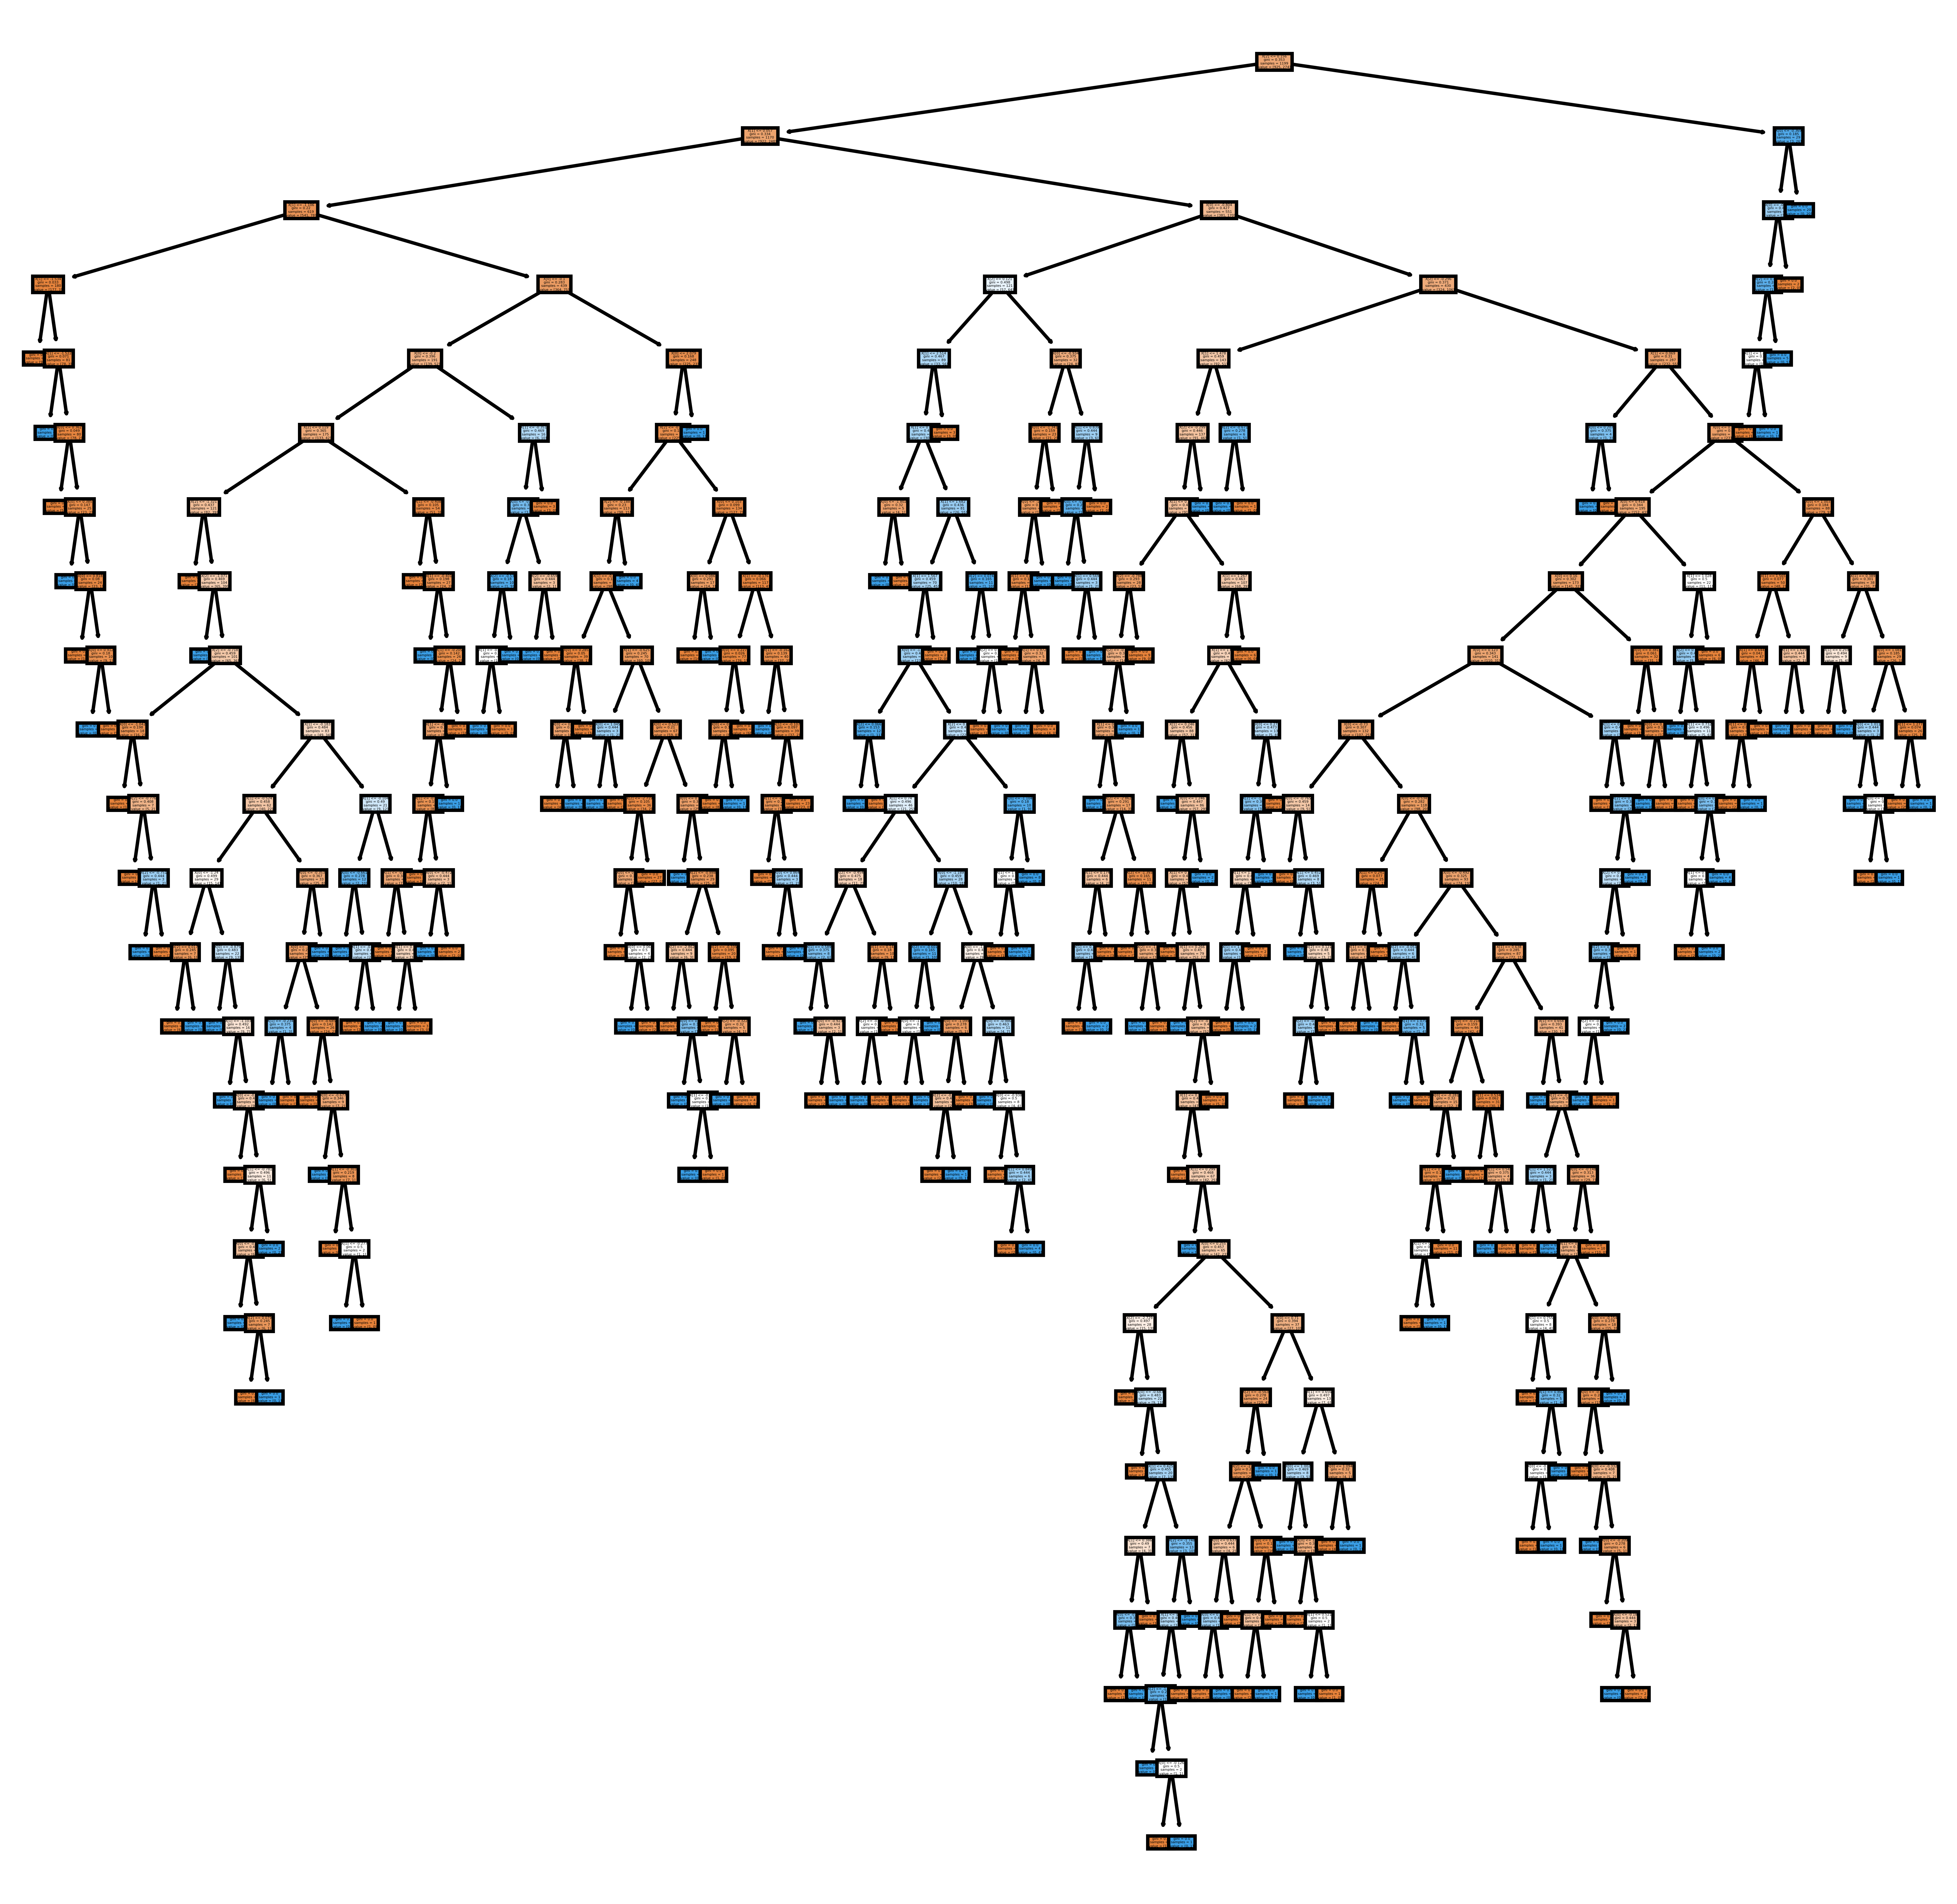

In [148]:
# Decision tree graph
import matplotlib.pyplot as plt

decision_tree_fig, dt_axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi=800)

_ = tree.plot_tree(DecisionTree,
                   filled = True);

#take a closer look at the decision tree
decision_tree_fig.savefig('decision_tree.png')

In [149]:
y_pred = DecisionTree.predict(wf_features_test)
y_pred[:10], wf_class_test[:10]

(array([0, 0, 0, 1, 1, 0, 1, 1, 0, 0]), array([0, 0, 0, 1, 1, 0, 1, 1, 0, 0]))

In [151]:
from sklearn.metrics import classification_report

# make predictions
dt_expected = wildfire_labels
dt_predicted = DecisionTree.predict(wildfire_features)

# summarize the fit of the model
print(classification_report(dt_expected, dt_predicted))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1327
           1       0.86      0.84      0.85       386

    accuracy                           0.93      1713
   macro avg       0.91      0.90      0.90      1713
weighted avg       0.93      0.93      0.93      1713



A good explanation for the classification report can be found on Yellowbrick's documentation: https://www.scikit-yb.org/en/latest/api/classifier/classification_report.html
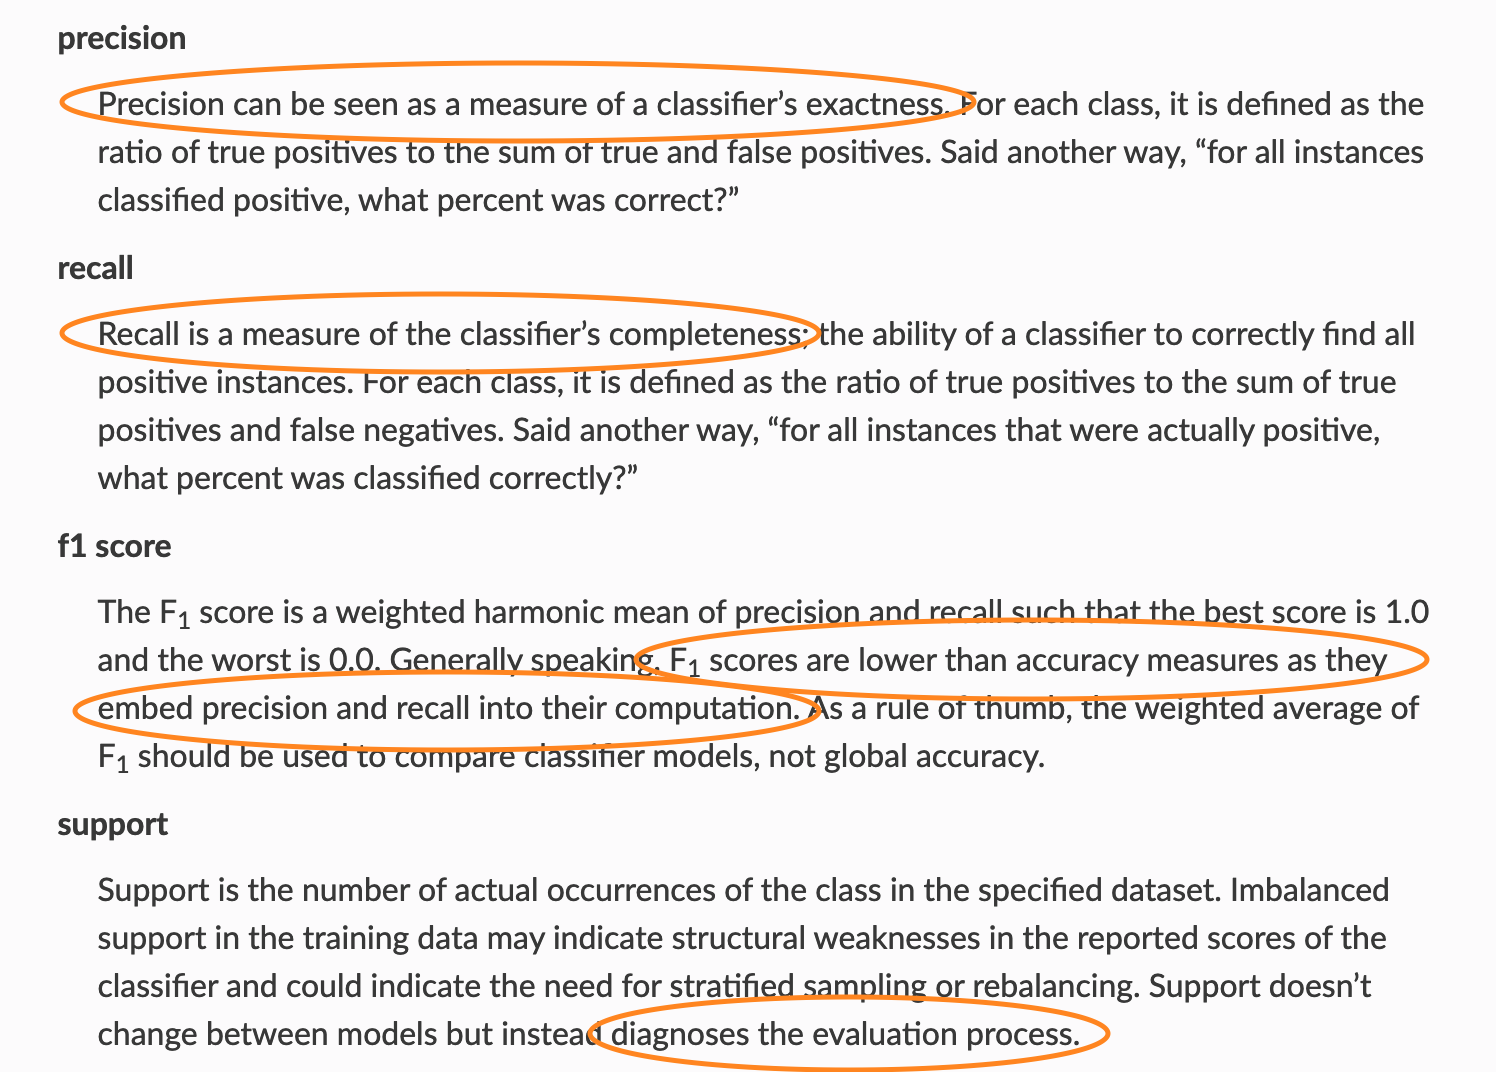

### Random Forest

A random forest algorithm is comprised of many decision trees which iterate over the dataset. The advantage to using a random forest is that it searches for the best feature among a random subset of the features. It then averages out the result of all of the descision trees to produce predictions. Using many descision trees creates diversity and generally results in a better model.

While random forest is a collection of decision trees, there are some differences.
If you input a training dataset with features and labels into a decision tree, it will formulate some set of rules, which will be used to make the predictions. In comparison, the random forest algorithm randomly selects observations and features to build several decision trees and then averages the results. Another difference is "deep" decision trees might suffer from overfitting. Most of the time, random forest prevents this by creating random subsets of the features and building smaller trees using those subsets. 

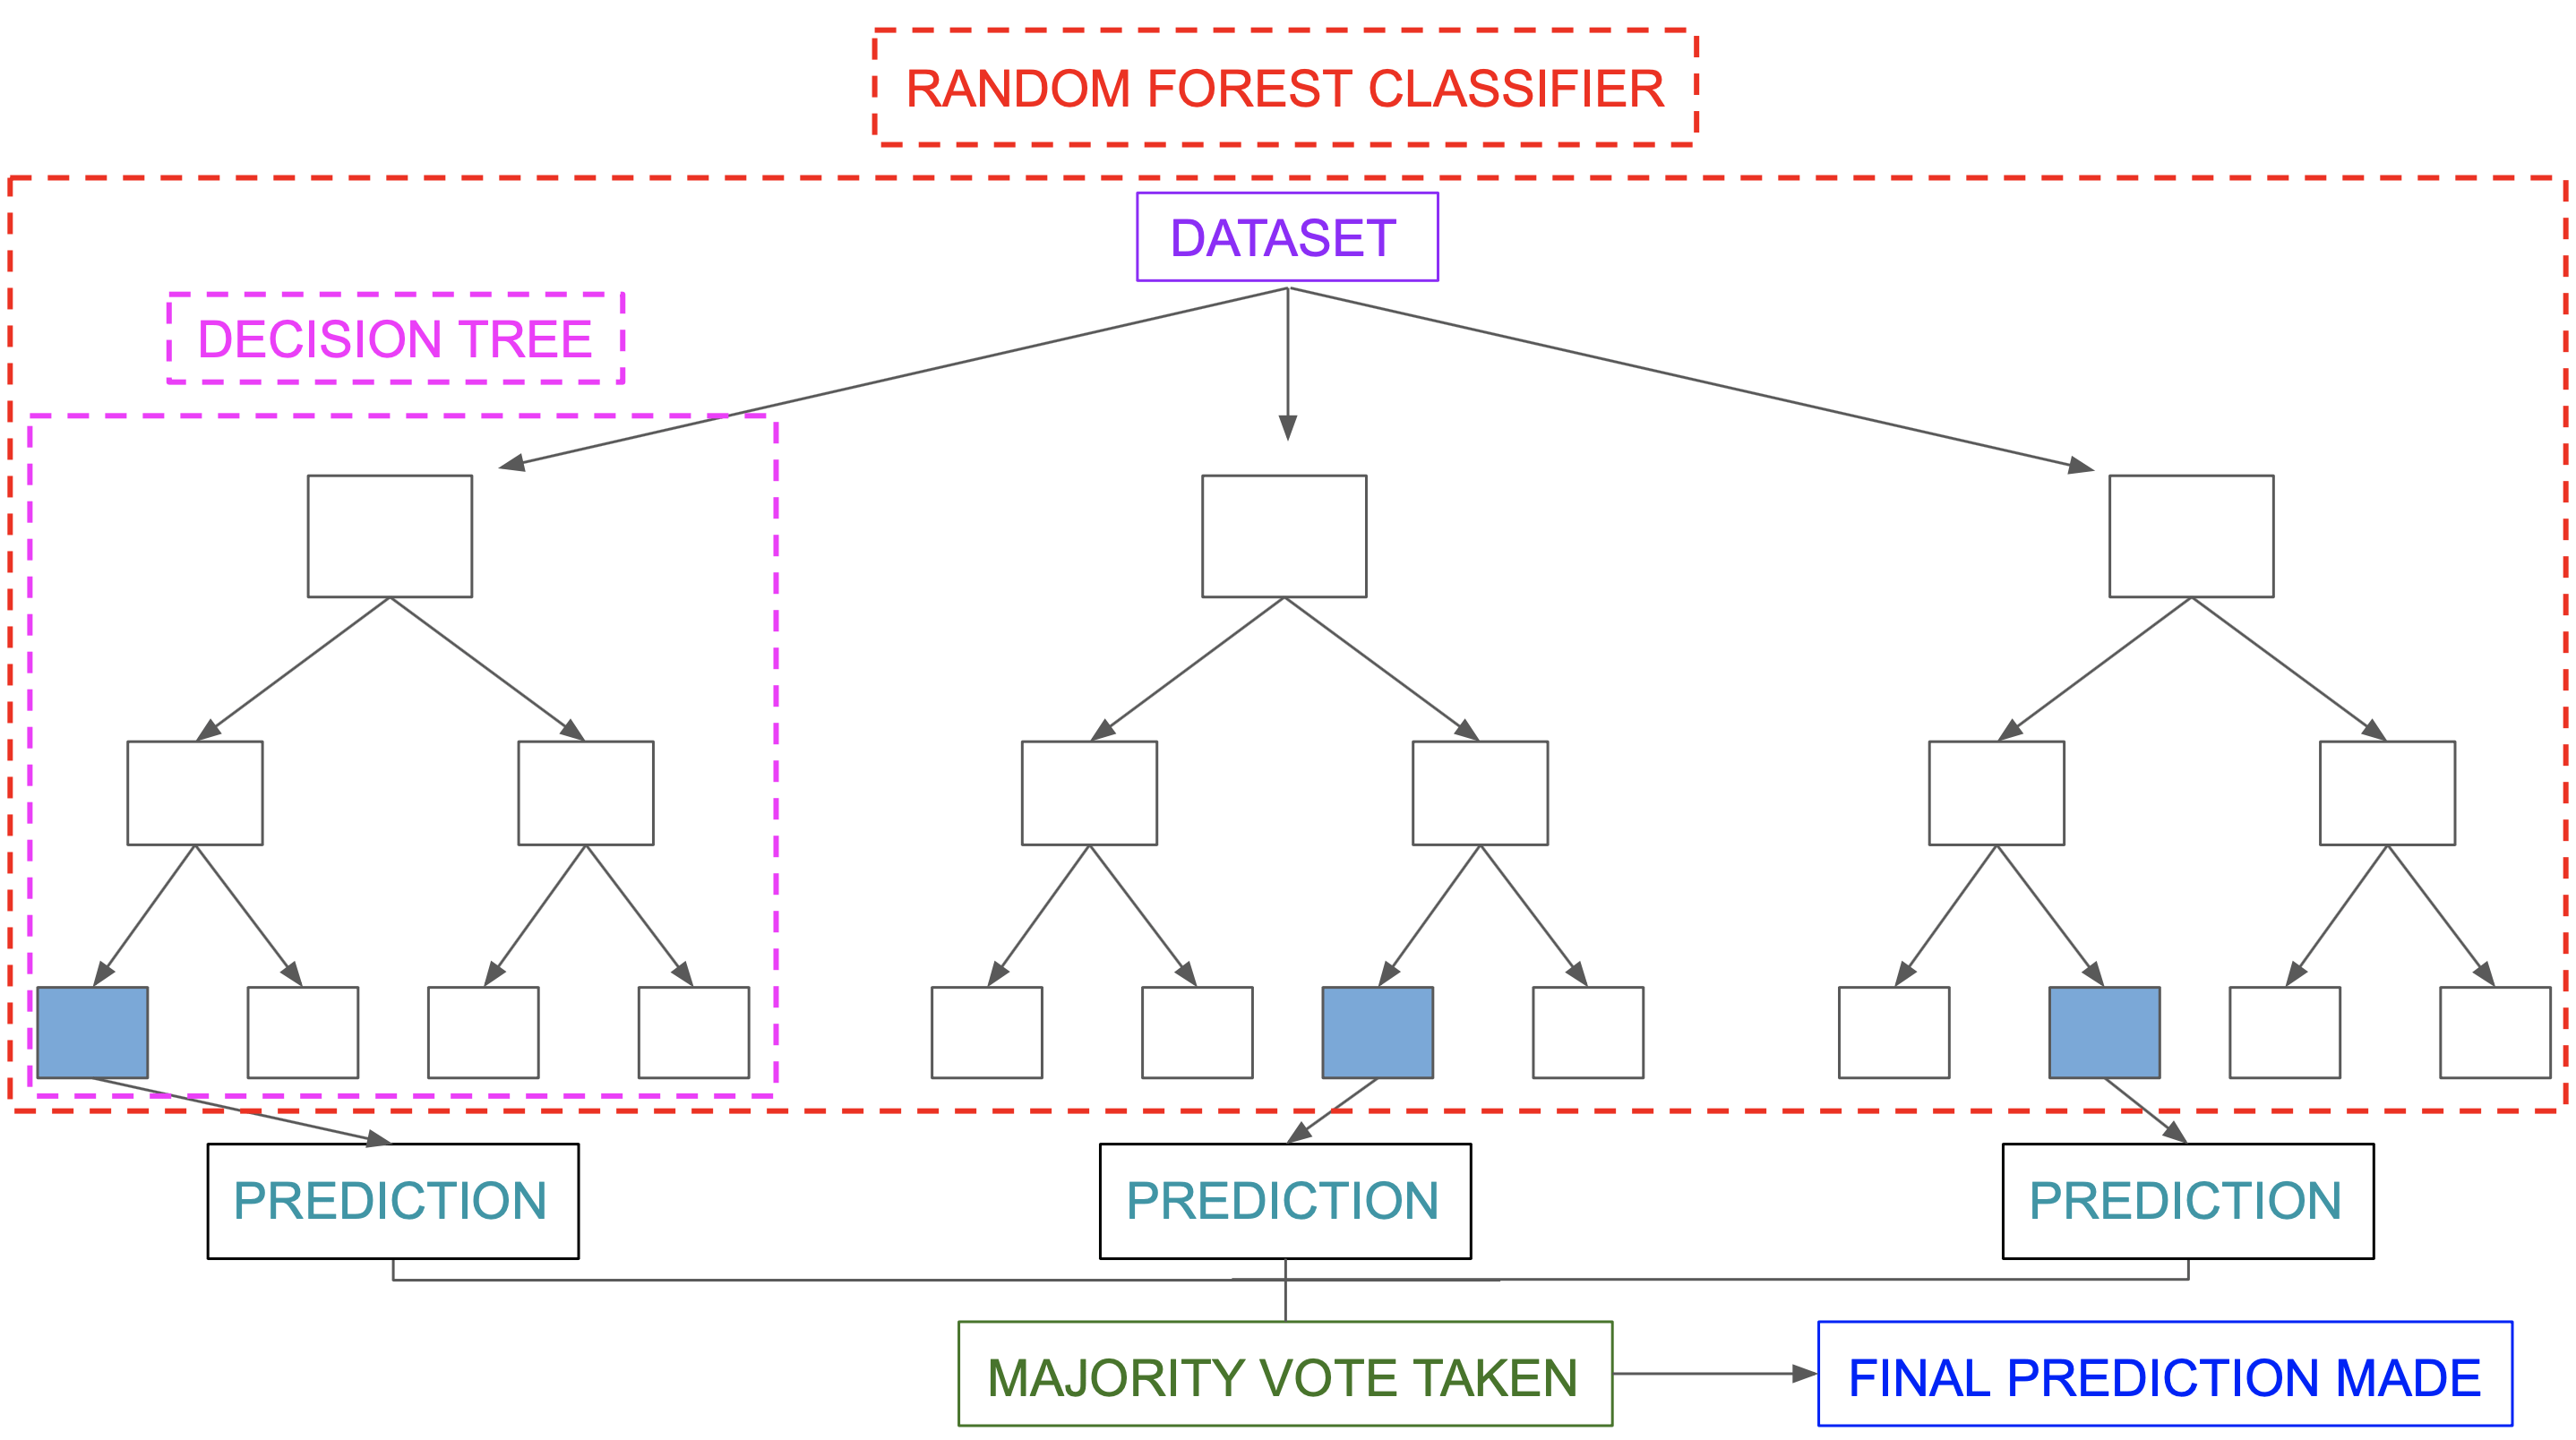

Image from: https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/

In [152]:
from sklearn.ensemble import RandomForestClassifier
# random forest method
RandomForest = RandomForestClassifier()
RandomForest = RandomForest.fit(wf_features_train, wf_class_train)

# Compare prediction with test dataset
y_pred = RandomForest.predict(wf_features_test)
y_pred[:10], wf_class_test[:10]

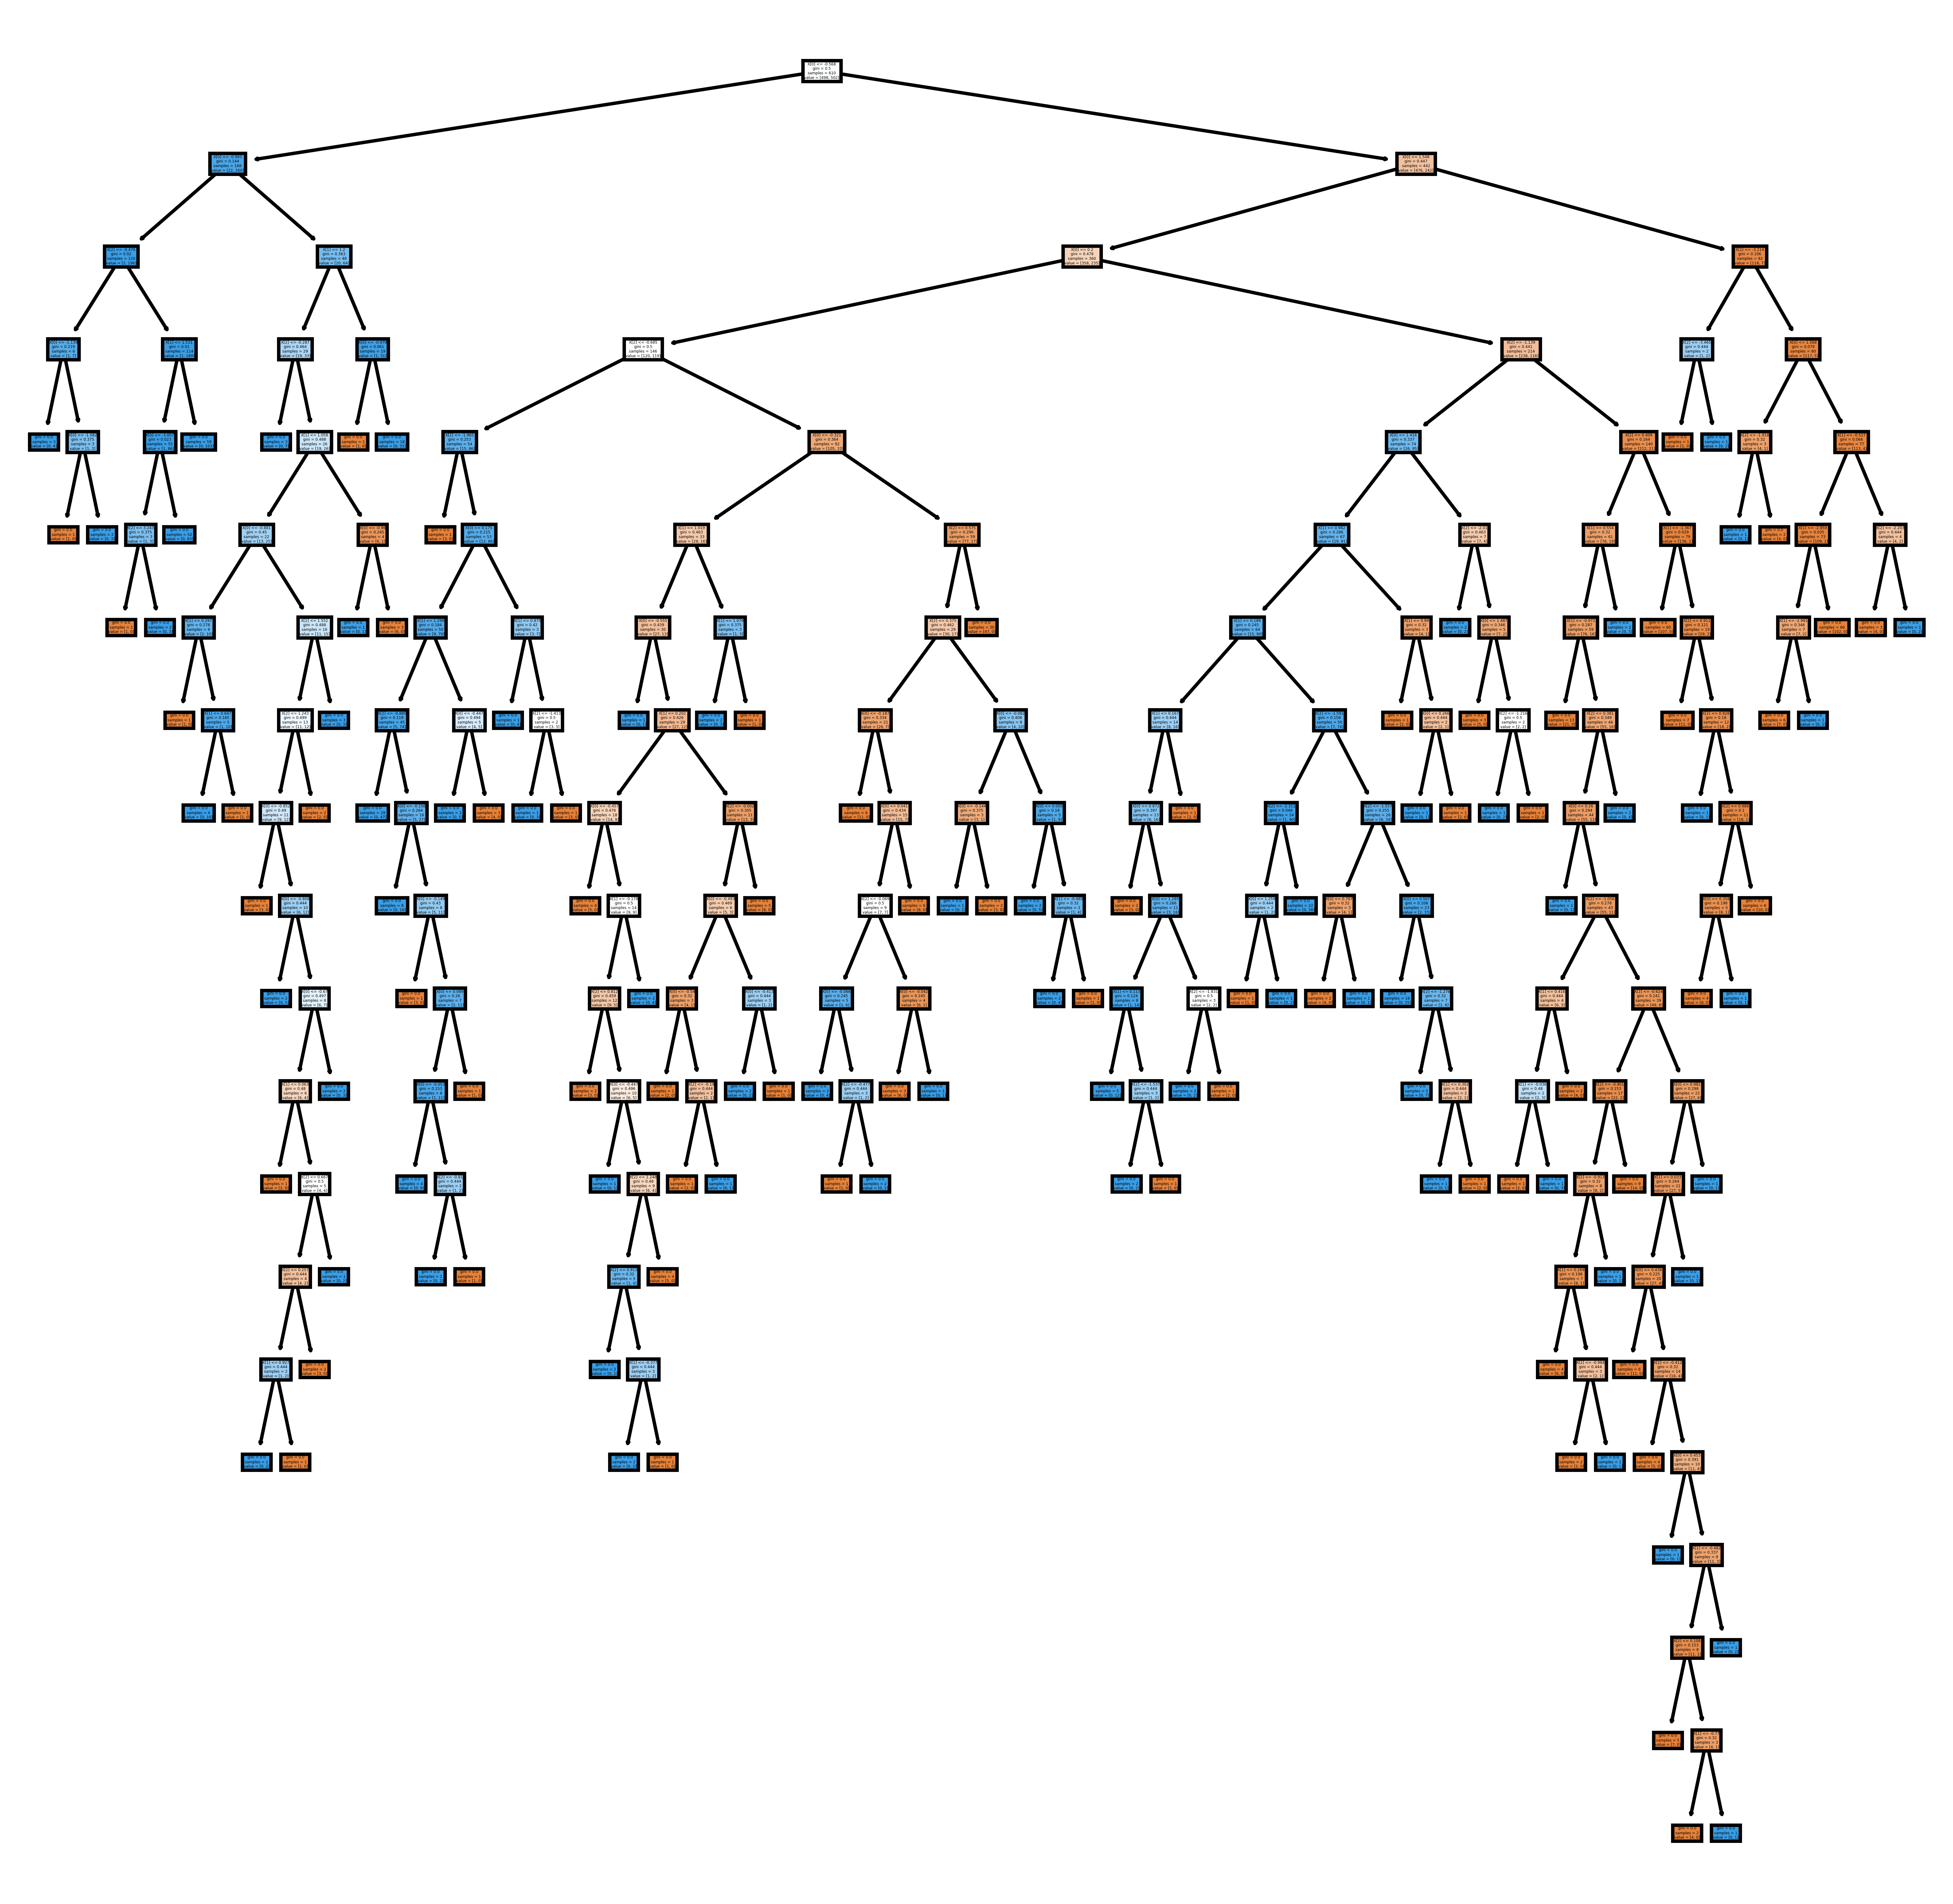

In [156]:
#viewing the tree graph
randomforest_fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi=800)

tree.plot_tree(RandomForest.estimators_[0], filled = True);

randomforest_fig.savefig('randomforest_individualtree.png')

In [157]:
# Evaluate through confusion matrix

# make predictions
rf_expected = wildfire_labels
rf_predicted = RandomForest.predict(wildfire_features)

# summarize the fit of the model
print(classification_report(rf_expected, rf_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       499
           1       1.00      1.00      1.00       501

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



### Support Vector Machine (SVM)

A support vector machine is an algorithm that creates a boundary (a hyperplane) where the data points of the features have the most distance between each other and are thus most distinct. The hyperplane indicates the division between classes. Data points falling on opposite sides of the hyperplane belong to different classes.

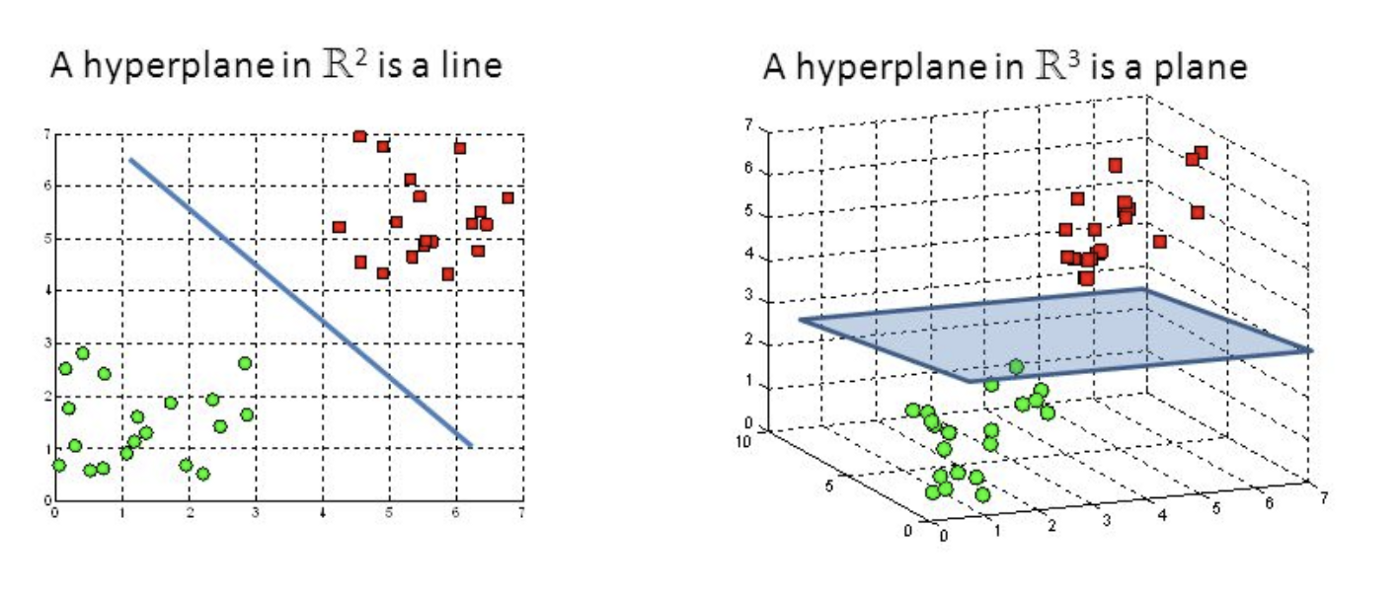

Image from: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [186]:
from sklearn.svm import SVC

# Support Vector Machine
SupportVectorMachine = SVC(gamma='scale')
SupportVectorMachine.fit(wf_features_train, wf_class_train)

# Compare prediction with test dataset
y_pred = SupportVectorMachine.predict(wf_features_test)
y_pred[:10],wf_class_test[:10]

SVC()

In [190]:
# Evaluate through confusion matrix
# make predictions
svm_expected = wildfire_labels
svm_predicted = SupportVectorMachine.predict(wildfire_features)
# summarize the fit of the model
print(classification_report(svm_expected, svm_predicted))

              precision    recall  f1-score   support

           0       0.52      0.99      0.68       499
           1       0.92      0.09      0.17       501

    accuracy                           0.54      1000
   macro avg       0.72      0.54      0.43      1000
weighted avg       0.72      0.54      0.43      1000



### Neural Network

A neural network is a deep learning model that is designed to mimic how neurons function in the brain. Every neural network has an input layer that receives data, at least one hidden layer, and an output layer. Each layer is comprised of nodes with a specific threshold. As data passes through a node in a layer, if its threshold is met the node activates and passes the data onto the next layer. If its theshold is not met, the node does not pass the data on. 

Fully trained neural networks can cluster and make sense of an incredible amount of data in a short amount of time. 

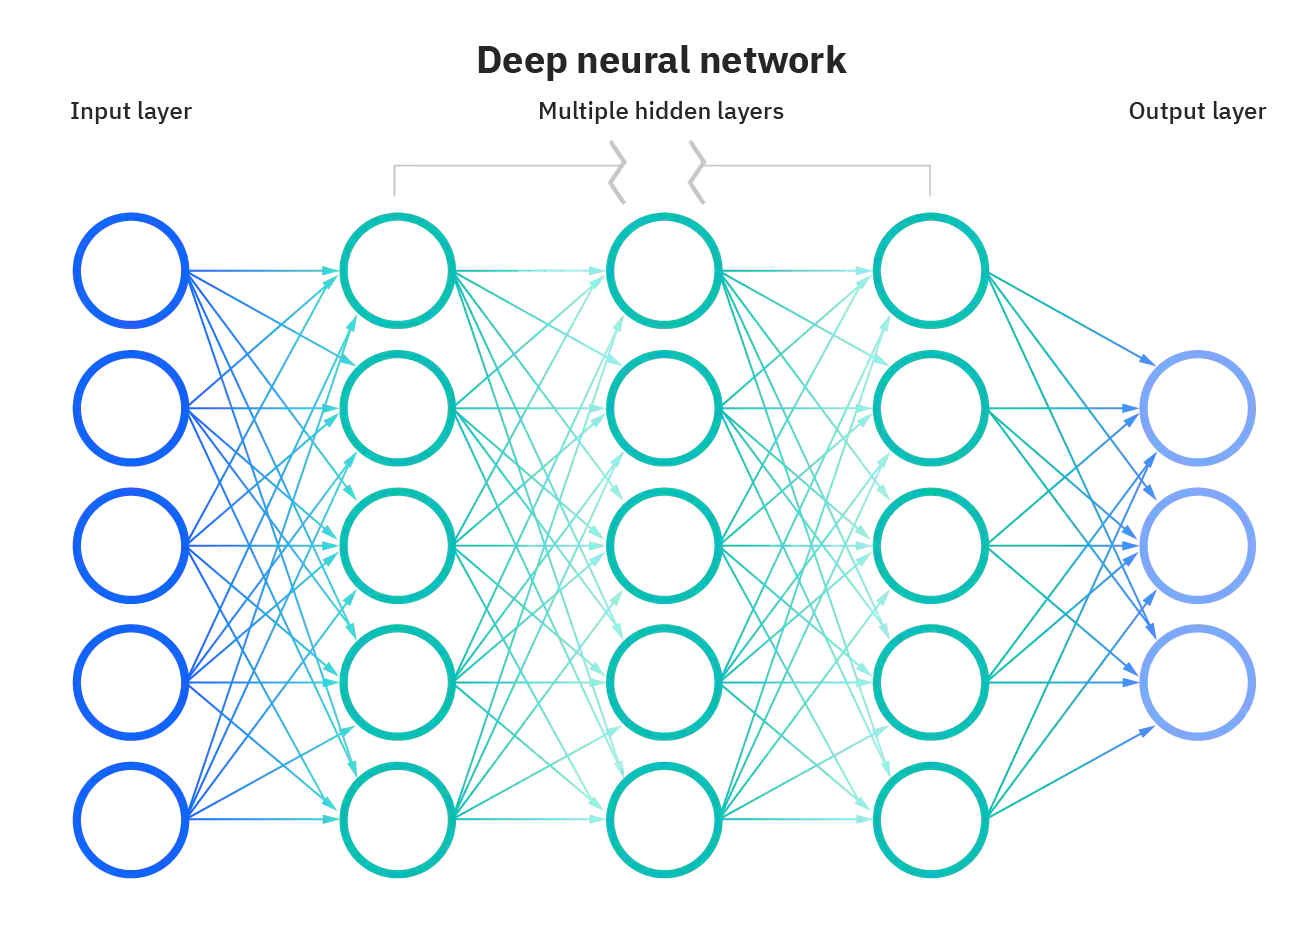

Image from: https://www.ibm.com/cloud/learn/neural-networks

This neural network will have one input layer which is activated with the first .add line, one hidden layer and an output layer. Since we wanted to predict two classes, a sigmoid output layer was chosen. Softmax is an alternative that can be used when attempting to predict multiple classes.

In [211]:
#defining my model
from keras.models import Sequential
from keras.layers import Dense
from sklearn import model_selection

neural_net = Sequential()
neural_net.add(Dense(12,input_shape=(3,),activation='relu'))
neural_net.add(Dense(8, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))

In [212]:
neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [213]:
neural_net.fit(wf_features_train, wf_class_train, epochs=300, shuffle=True, batch_size=3)

Epoch 1/300
400/400 [==============================] - 1s 879us/step - loss: 0.5406 - accuracy: 0.7665
Epoch 2/300
400/400 [==============================] - 0s 853us/step - loss: 0.4926 - accuracy: 0.7715
Epoch 3/300
400/400 [==============================] - 0s 869us/step - loss: 0.4866 - accuracy: 0.7715
Epoch 4/300
400/400 [==============================] - 0s 889us/step - loss: 0.4825 - accuracy: 0.7731
Epoch 5/300
400/400 [==============================] - 0s 920us/step - loss: 0.4792 - accuracy: 0.7748
Epoch 6/300
400/400 [==============================] - 0s 911us/step - loss: 0.4756 - accuracy: 0.7790
Epoch 7/300
400/400 [==============================] - 0s 906us/step - loss: 0.4726 - accuracy: 0.7798
Epoch 8/300
400/400 [==============================] - 0s 905us/step - loss: 0.4710 - accuracy: 0.7807
Epoch 9/300
400/400 [==============================] - 0s 1ms/step - loss: 0.4685 - accuracy: 0.7815
Epoch 10/300
400/400 [==============================] - 0s 900us/step - los

In [243]:
#using the training neural net to make predications on the test set
y_pred = neural_net.predict(wf_features_test)
y_pred = np.array(y_pred, dtype= np.float16)

In [244]:
#Making the neural network predictions binary instead of continuous
convert_pred = []
for i in y_pred:
    if i > .5:
        convert_pred.append(1)
    else:
        convert_pred.append(0)

In [241]:
# make predictions
nn_expected = wf_class_test
nn_predicted = convert_pred

# summarize the fit of the model
print(classification_report(nn_expected, nn_predicted))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       402
           1       0.62      0.26      0.36       112

    accuracy                           0.80       514
   macro avg       0.72      0.61      0.62       514
weighted avg       0.78      0.80      0.77       514



## Saving and Loading Models for Later Use

After we have gone through all of the trouble to train our models, we would like to save them for later use. This can be accomplished in two ways. One is through the dump and load functions in Sklearn and the other is through the .save method in Keras.

### Method 1: Sklearn

In [270]:
#saving our models using Sklearn
from joblib import dump, load

dump(DecisionTree, 'Wildfire_DecisionTree_model.joblib') 
dump(RandomForest, 'Wildfire_RandomForest_model.joblib') 
dump(SupportVectorMachine, 'Wildfire_SupportVectorMachine_model.joblib') 

['Wildfire_SupportVectorMachine_model.joblib']

Any of the saved models can then later be recalled using the load function.

In [261]:
from sklearn import datasets

#the Linnerud dataset is an example dataset with 3 features
#it is being called as an example of your new data that you would like to train your model with
X, y= datasets.load_linnerud(return_X_y=True)

latest_DecisionTree = load('Wildfire_DecisionTree_model.joblib') 
latest_DecisionTree.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Method 2: Keras

In [262]:
#save the Neural Net using Keras
neural_net.save('Wildfire_proj/Wildfire_NeuralNet_model.h5')

In [263]:
#load the saved model
reconstructed_neural_net = keras.models.load_model('Wildfire_proj/Wildfire_NeuralNet_model.h5')
reconstructed_neural_net.fit(wf_features_test, wf_class_test, epochs=10, batch_size=2)

Epoch 1/10
257/257 [==============================] - 0s 866us/step - loss: 0.5340 - accuracy: 0.8054
Epoch 2/10
257/257 [==============================] - 0s 826us/step - loss: 0.5104 - accuracy: 0.8035
Epoch 3/10
257/257 [==============================] - 0s 815us/step - loss: 0.4966 - accuracy: 0.8016
Epoch 4/10
257/257 [==============================] - 0s 784us/step - loss: 0.4877 - accuracy: 0.8132
Epoch 5/10
257/257 [==============================] - 0s 873us/step - loss: 0.4810 - accuracy: 0.8210
Epoch 6/10
257/257 [==============================] - 0s 792us/step - loss: 0.4755 - accuracy: 0.8171
Epoch 7/10
257/257 [==============================] - 0s 801us/step - loss: 0.4721 - accuracy: 0.8171
Epoch 8/10
257/257 [==============================] - 0s 834us/step - loss: 0.4674 - accuracy: 0.8191
Epoch 9/10
257/257 [==============================] - 0s 801us/step - loss: 0.4642 - accuracy: 0.8210
Epoch 10/10
257/257 [==============================] - 0s 800us/step - loss: 0.459

In [275]:
#a quick and dirty evaluation on the old vs. new model
y1 = reconstructed_neural_net.evaluate(wf_features_test, wf_class_test)
y2 = neural_net.evaluate(wf_features_test, wf_class_test)

17/17 [==============================] - 0s 834us/step - loss: 0.5352 - accuracy: 0.8035


In [276]:
#comparing the performance of the two models
print(f'New Model: Test loss: {round(y1[0],2)} / New Model: Test accuracy: {round(y1[1],2)}')
print(f'Old Model: Test loss: {round(y2[0],2)} / Old Model: Test accuracy: {round(y2[1],2)}')

New Model: Test loss: 0.45 / New Model: Test accuracy: 0.82
Old Model: Test loss: 0.54 / Old Model: Test accuracy: 0.8


## End

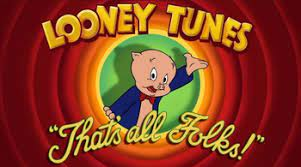